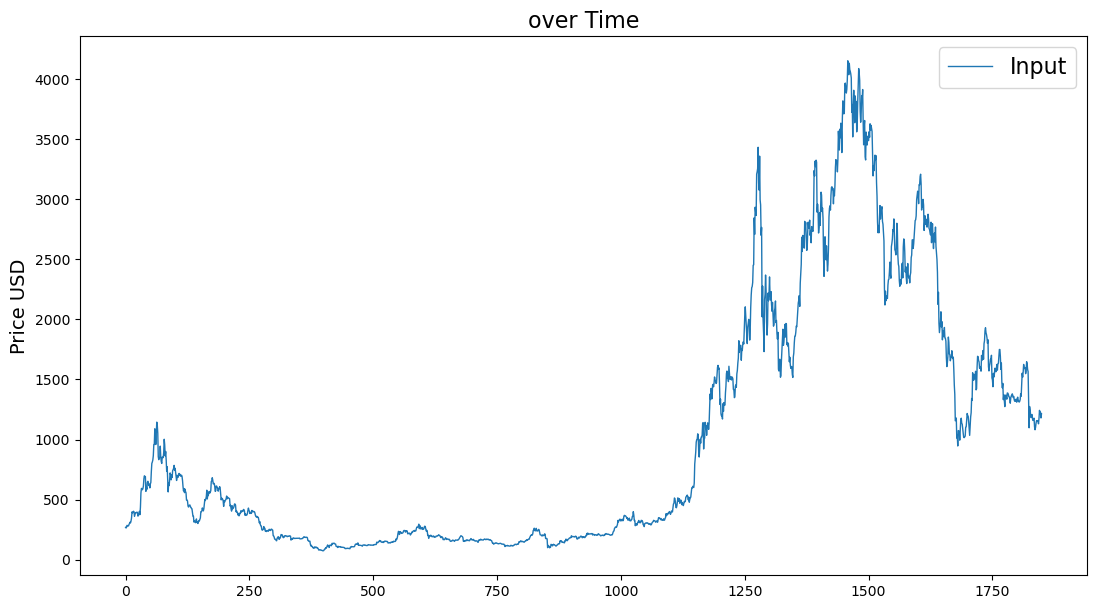

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Set the random seed for reproducibility
np.random.seed(42)

# Load the data
df = pd.read_csv('ETH-EUR_11_11_2017-07_12_2022.csv', usecols=[4], engine='python', skipfooter=3)

# # Plot the data
# plt.plot(df)
# plt.show()
#
# btc_trace = go.Scatter(x=df.index, y=df['Open'], name= 'Price')
# py.iplot([btc_trace])

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df, label='Input', linewidth=1)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('over Time', fontsize=16)
ax.legend(loc='best', fontsize=16)


In [24]:

# Convert the data to a NumPy array
data = df.values
data = data.astype('float32')
df = data.copy()
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Split the data into training and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]


In [25]:

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [26]:

# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [27]:

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [28]:

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
results = model.fit(trainX, trainY, epochs=100, batch_size=5, verbose=2)



Epoch 1/100
248/248 - 2s - loss: 0.0084 - 2s/epoch - 7ms/step
Epoch 2/100
248/248 - 0s - loss: 0.0062 - 231ms/epoch - 931us/step
Epoch 3/100
248/248 - 0s - loss: 0.0048 - 238ms/epoch - 960us/step
Epoch 4/100
248/248 - 0s - loss: 0.0033 - 241ms/epoch - 972us/step
Epoch 5/100
248/248 - 0s - loss: 0.0017 - 244ms/epoch - 984us/step
Epoch 6/100
248/248 - 0s - loss: 5.4305e-04 - 232ms/epoch - 935us/step
Epoch 7/100
248/248 - 0s - loss: 1.3091e-04 - 233ms/epoch - 940us/step
Epoch 8/100
248/248 - 0s - loss: 6.1251e-05 - 241ms/epoch - 972us/step
Epoch 9/100
248/248 - 0s - loss: 5.5048e-05 - 232ms/epoch - 935us/step
Epoch 10/100
248/248 - 0s - loss: 5.4689e-05 - 238ms/epoch - 960us/step
Epoch 11/100
248/248 - 0s - loss: 5.5233e-05 - 230ms/epoch - 927us/step
Epoch 12/100
248/248 - 0s - loss: 5.5515e-05 - 232ms/epoch - 935us/step
Epoch 13/100
248/248 - 0s - loss: 5.4621e-05 - 235ms/epoch - 948us/step
Epoch 14/100
248/248 - 0s - loss: 5.4115e-05 - 230ms/epoch - 927us/step
Epoch 15/100
248/248 - 0s 

In [29]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)



In [30]:

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [31]:

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 26.97 RMSE
Test Score: 235.40 RMSE


In [32]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict



In [33]:
# Shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict



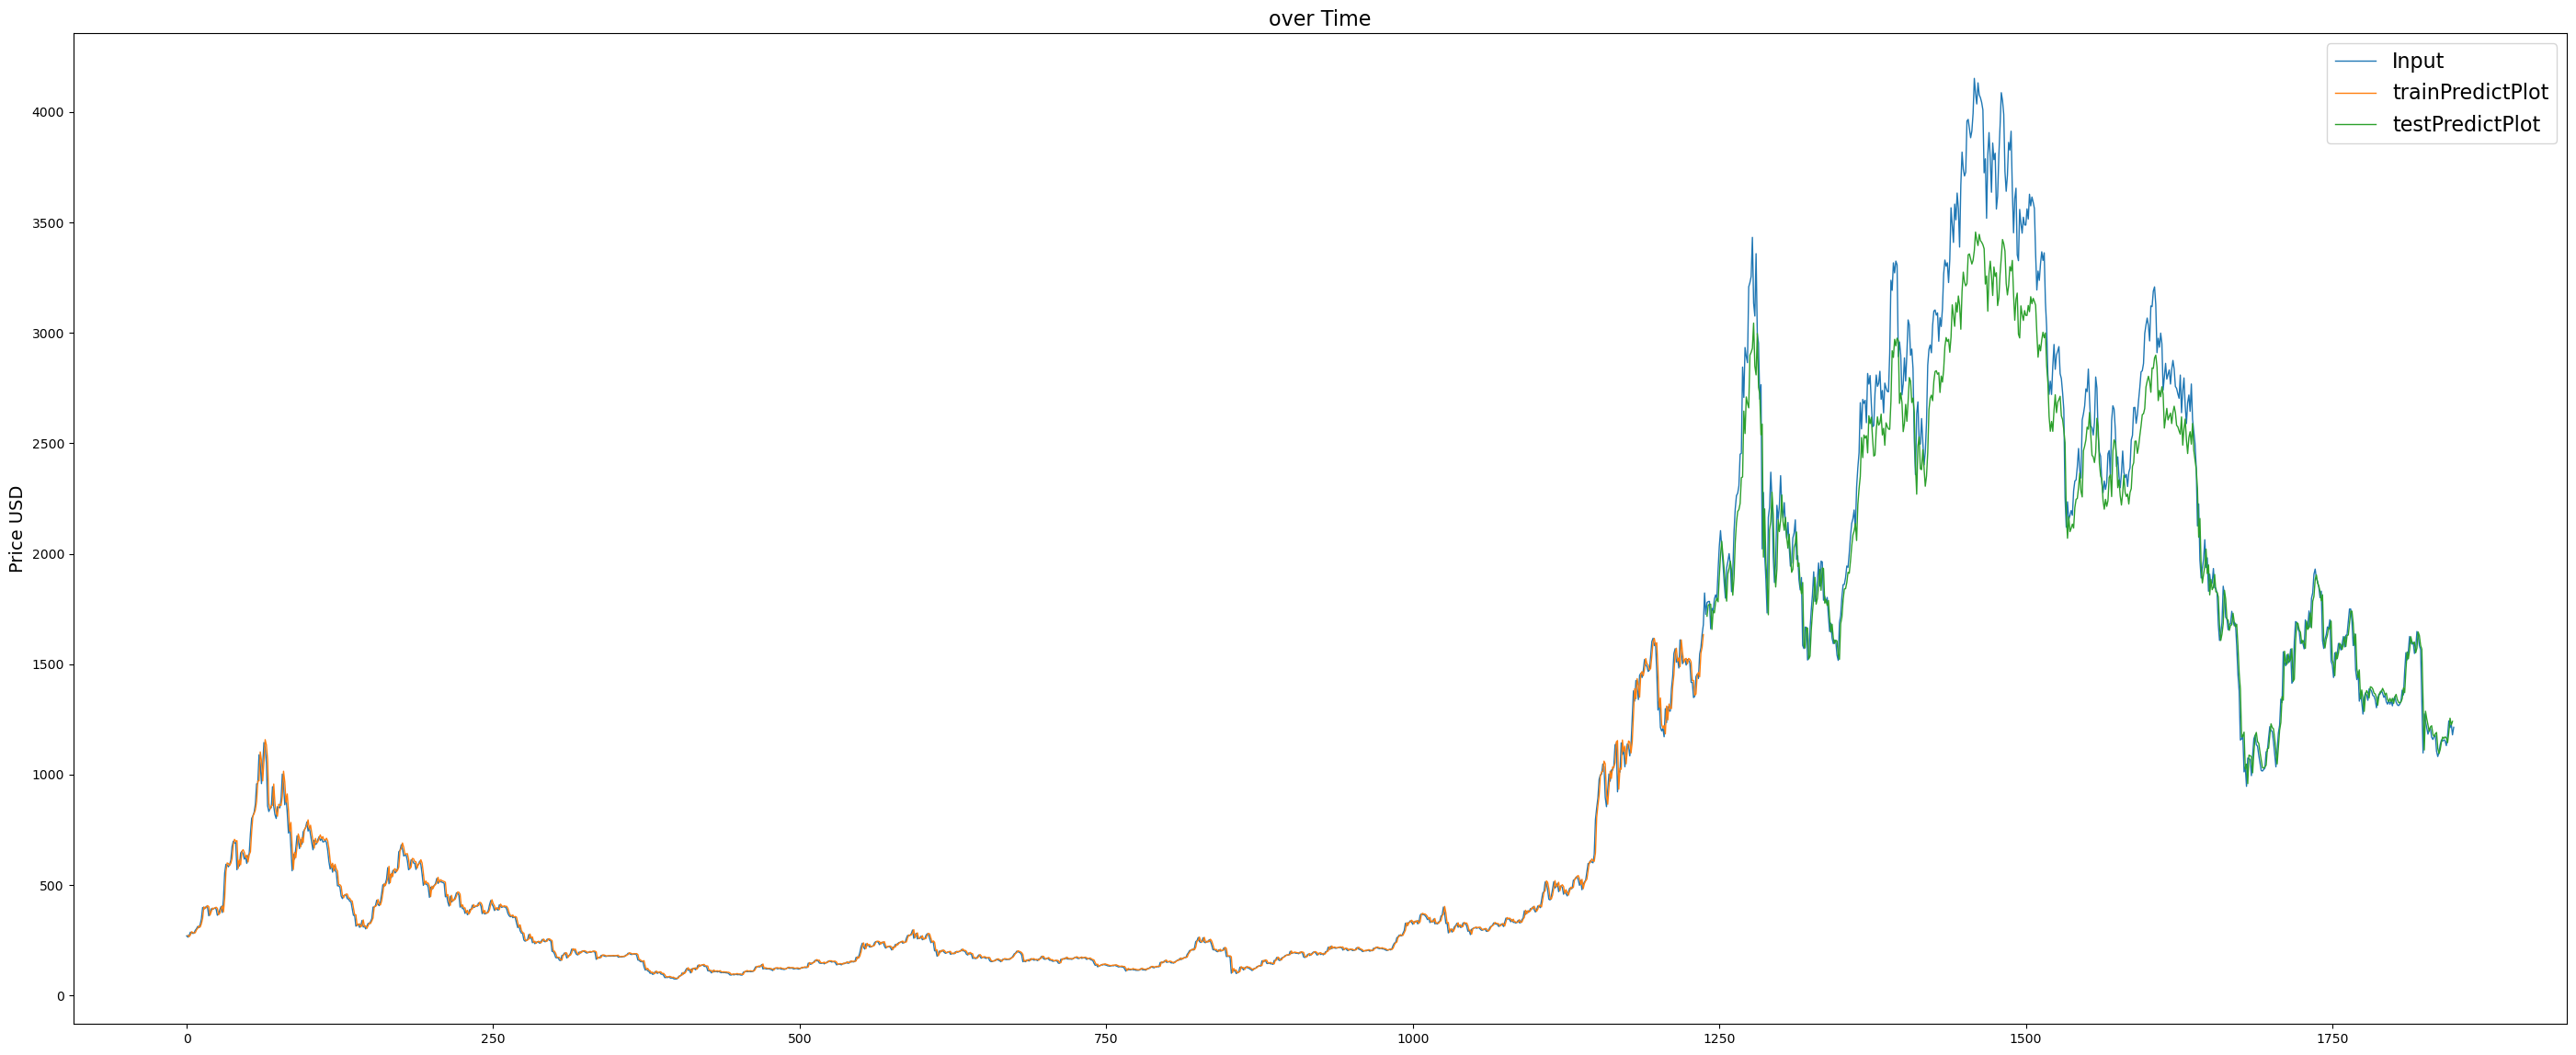

In [34]:
# # Plot baseline and predictions
# plt.plot(scaler.inverse_transform(data))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
#

fig, ax = plt.subplots(1, figsize=(35, 14))
ax.plot(scaler.inverse_transform(data), label='Input', linewidth=1)
ax.plot(trainPredictPlot, label='trainPredictPlot', linewidth=1)
ax.plot(testPredictPlot, label='testPredictPlot', linewidth=1)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('over Time', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [35]:
from statsmodels.tsa.stattools import adfuller
# Daten einlesen
df = pd.read_csv('ETH-EUR_11_11_2017-07_12_2022.csv', index_col='Date', parse_dates=True)
df.index.freq = 'D'


# Daten auf Stationarität prüfen
adfuller(df['Close'])



# Daten differenzieren
df_diff = df.diff()
df_diff = df_diff.dropna()


start = len(df_diff)
end = len(df_diff) + 180

predictions = results.model.predict(start=start, end=end, dynamic=False).rename('LSTM Predictions')

# Vorhersage plotten
df['Close'].plot(figsize=(12,5), legend=True)
predictions.plot(legend=True)
plt.show()

TypeError: Model.predict() got an unexpected keyword argument 'start'